# 训练深度强化学习代理来玩“星际争霸 II (StarCraft II)”

欢迎来到本实验！开始之前，我们先来了解一下 Jupyter Notebook 上的一些指标。

1.您可以使用浏览器打开 Jupyter Notebook 笔记本，不过具体内容则由在支持 AWS EC2 GPU 的实例上运行的交互式 iPython 内核进行流式传输。

2.此笔记本由若干单元组成；单元中会包含您所能运行的代码，也能保存供您阅览的文本或图像。

3.您可以通过单击菜单中的 ```Run```（运行）图标，或通过以下键盘快捷键 ```Shift-Enter```（运行并执行下一个）或 ```Ctrl-Enter```（运行并停留在当前单元）来执行代码单元。

4.如要中止执行单元，请单击工具栏上的 ```Stop```（停止）按钮或前往 ```Kernel```（内核）菜单，并选择 ```Interrupt ```（中断）。

我是一个标注单元 - 如果您运行我，我就会变为静态文本。

In [1]:
1 + 1  # i'm a code cell -- if you run me I'll perform some computations and show you their result below

2

# 强化学习 (RL)

强化学习是机器学习的一个子领域，在此领域中，学习代理并非使用标注好的数据集，而是通过与环境交互来构建自己的经验数据集。最初，代理的动作是随机的，但当其偶然发现良好的行为时，便会受到环境的奖励，而且此奖励信号允许代理更新自身参数，以便日后能够将其所获奖励最大化。

<img src="images/RL.jpg" width="95%"></img>

自从 Google 的 DeepMind 使用 RL 和深度学习 (DL) 训练 AI 代理，使其仅通过像素来学习玩游戏，并以此掌握 Atari 游戏技能后，RL 最近广受追捧。自那时起，DeepMind 就已使用深度强化学习 (DRL) 成功挑战了围棋游戏。

RL 要面临的下一个未攻克的艰巨挑战则是“星际争霸 II (StarCraft II)”- <a href="https://deepmind.com/blog/deepmind-and-blizzard-open-starcraft-ii-ai-research-environment/">了解详情</a>！

#“星际争霸 II (StarCraft II)”
“星际争霸 II (StarCraft II)”(SC2) 是一款由 Blizzard 开发的实时策略游戏，可供免费畅玩（<a href='https://starcraft2.com/en-us/'>游戏官方网站链接</a>）。
单击图片观看概述视频。

<a href='https://www.youtube.com/watch?v=yaqeZ9Snt4E'> <img src="images/sc2.jpg"></img> </a>
    
实时策略游戏需要玩家具备许多技能，包括：战略思维、准确或快速执行、信息收集或隐藏以及经济资源管理。在本实验中，我们将训练神经网络代理来玩迷你游戏，从而剥离并捕获全局游戏的一些基本技能。

<a href=""><img src="https://storage.googleapis.com/deepmind-live-cms-alt/documents/mini-games.gif" width="90%"></a>

# 实验组成部分

本实验由以下部分组成：

    
<ul>
<a href='#section1'>第 1 节</a>借助 DeepMind 的 Pysc2 API 以编程方式探索并掌握 SC2 的游戏技能
    <br>&nbsp;<br>
<a href='#section2'>第 2 节</a>了解如何使用奖励来塑造代理动作
    <br>&nbsp;<br>
<a href='#section3'>第 3 节</a>跟踪学习过程
    <br>&nbsp;<br>
<a href='#section4'>第 4 节</a> [混合与匹配] 在目标地图或新的陌生场景中部署训练后的代理
    <br>&nbsp;<br>
<a href='#section5'>第 5 节</a>在 Keras（TensorFlow 后端）构建或修改您自己的深度学习 SC2 代理
</ul>

In [2]:
import warnings; warnings.filterwarnings("ignore") # supress warnings

<a id='section1'></a>
# 第 1 节 - SC2 PyGame 客户端与 Python API

通过与 Blizzard 的协同合作，DeepMind 已发布一款高级 Python API (<a href="https://github.com/deepmind/pysc2">pysc2</a>)，我们可以用它来构建与“星际争霸 II (StarCraft II)”引擎进行交互的机器学习代理。

下面我们将通过以下导入命令将此库加载到我们的笔记本中：

In [3]:
import pysc2

接着我们可以尝试使用 pysc2 来启动一个采用 py-game 渲染客户端的迷你游戏，该客户端将会生成一个低分辨率游戏视图（而我们的深度学习代理在玩游戏时将会用到此视图）。

待加载的迷你游戏允许我们使用鼠标和键盘来控制 9 个人族太空<a href="http://us.battle.net/sc2/en/game/unit/marine">陆战队员</a>组成的小队，以此对抗 4 只一组的虫族<a href="http://us.battle.net/sc2/en/game/unit/roach">蟑螂</a>。

通过运行以下命令，您将能启动带有“消灭蟑螂 (DefeatRoaches)”地图的 sc2 py-game 客户端。



In [5]:
!python -m pysc2.bin.play --map DefeatRoaches --max_game_steps 2000 > /dev/null 2>&1

如要查看此地图并在其上游玩，我们需要打开另一个选项卡，该选项卡将会运行一个远程图形桌面连接，而实验运行在AWS 云的实例中。


###<center>单击 [noVNC Server](http://ec2-18-221-145-178.us-east-2.compute.amazonaws.com:6900/?password=vncpassword)（noVNC 服务器）查看 Pysc2 客户端。</center>

接着，我们来启动游戏客户端，该客户端应会在 VNC 查看器中显示出来。注意，在 600 个游戏步骤结束之后，迷你游戏将会关闭，不过您可以再次重启（通过再次运行单元或继续进行余下内容）。注意：请使用 Internet Explorer 或 Microsoft Edge，因为其他浏览器可能不支持您与游戏交互。

现在，您应能选择 VNC 查看器中显示的 GUI 游戏并与之交互。单击并拖动以选择（绿色的陆战队员圈），然后右键单击您想将所选单位移至的目标位置。


<img src="images/marine_vs_roach.jpg" width="50%"></img><img src="images/marine_vs_roach_in_game.jpg" width="50%"></img>

如果您想进一步探索，也可以试试其他迷你游戏，只需将以上单元中的“消灭蟑螂 (DefeatRoaches)”替换成其他的地图名即可。以下列出了一些可供您启动的迷你游戏。

*“收集散落水晶 (CollectMineralShards)”
*“消灭小狗和毒爆虫 (DefeatZerglingsAndBanelings)”
*“寻找并消灭小狗 (FindAndDefeatZerglings)”
*“寻路 (MoveToBeacon)”

每个迷你游戏都试图教授 AI 一种掌控 SC2 所需的不同技能。代理必须学会什么技能才能掌控“消灭蟑螂 (DefeatRoaches)”？

<b>常见问题解答：</b>一些浏览器在 VNC 会话中不支持交互式游戏 - 尝试切换浏览器或禁用扩展程序。

## 1.2 - 以编程方式探索环境观测结果

接下来，我们将学习如何通过编程来创建 SC2 环境并与之交互。我们不直接使用鼠标和键盘，而是使用函数式 API 来探索 SC2 py-game 客户端产生的观测结果，并发出命令。

<img src="images/sc2_RL_environment.png" style="height:350px">

In [6]:
import numpy as np
import matplotlib.pylab as plt

# required 
from absl import flags
FLAGS = flags.FLAGS
FLAGS(['--'])

# note this import must happen after flag initialization
from pysc2.env import sc2_env
from pysc2.lib import actions
from pysc2.lib import features

# define environment flags
env_args = dict(
        map_name='DefeatRoaches',
        step_mul=1, # How many time steps occur between each action-decision. A step_mul of 1 means an agent can choose one action per frame.
        game_steps_per_episode=0, # no limit- but each map has a built-in max number of steps and will terminate after reaching that.
        screen_size_px = ( 64, 64 ), 
        minimap_size_px = ( 32, 32 ),
        visualize = True,
        score_index = None
)

In [7]:
# spawn the environment -- may take a minute to launch
env = sc2_env.SC2Env(**env_args) # ** syntax implies variable number named arguments
obs = env.reset()




Pysc2 可用于 Linux、Windows 或 MacOS 系统。我们将在本实验中使用 Linux 实例，不过您也可下载代理的回放，然后在 Windows 或 Mac 设备上查看。

现在，我们可以检阅 sc2 Linux 模拟器在每个游戏步骤后提供的原始观测结果样本。

In [8]:
obs[0]

TimeStep(step_type=<StepType.FIRST: 0>, reward=0, discount=1.0, observation={'cargo': array([], shape=(0, 7), dtype=int32), 'minimap': array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       ...,

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],



观测结果中包含众多有趣的数据元素。如果仔细观察，您应能找到当前时间步的奖励信息、累积分数以及许多有关游戏世界现状的其他细节，包括现有动作。由于我们刚刚踏入一个全新的游戏世界，因此这些值中有许多尚无具体信息可供参考；不过，待我们执行一些动作后，稍后就能再次返回查看这些值。下面我们就来演示一下如何获取它们的值。

In [9]:
print( 'current reward: ', obs[0].reward )
print( 'cumulative score: ', obs[0].observation['score_cumulative'][0])
print( 'available data elements: ', obs[0].observation.keys())

('current reward: ', 0)
('cumulative score: ', 0)
('available data elements: ', ['cargo', 'minimap', 'game_loop', 'available_actions', 'screen', 'control_groups', 'multi_select', 'cargo_slots_available', 'player', 'single_select', 'build_queue', 'score_cumulative'])


我们要特别关注一下屏幕的视觉层。

这些可见的“特征层”代表各种游戏元素，如单位类型、单位所有者（玩家 1 与玩家 2）、单位生命值以及游戏状态的其他重要方面。每个特征层都作为网络的一个单独输入而提供，但由于这些特征层共用同一个空间参考框架，因此我们可将它们看作不同的通道或维度，共同构成对游戏状态的完整表示（即类似于红、绿、蓝三种颜色通道在照片中的呈现方式）

<img src="images/feature_layers.png" style="height:350px">
<center>
**注意，这是在一场后期战斗中对非常活跃的屏幕进行的可视化。在玩迷你游戏时，我们不会看到如此复杂的场景。*
</center>


首先，我们将可视化所有数据通道及其名称。

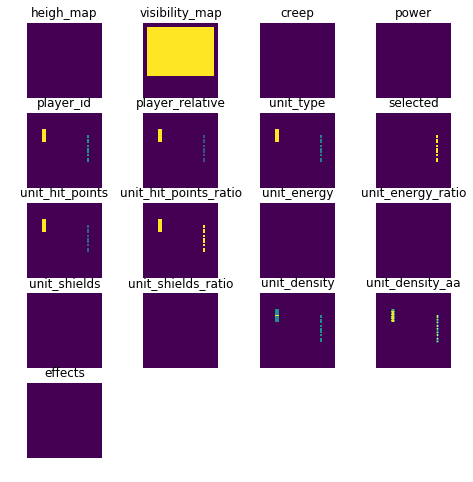

In [10]:
numScreenLayers = obs[0].observation['screen'].shape[0] # 17

plt.figure(figsize=(8,8))
titles = ['heigh_map', 'visibility_map', 'creep', 'power', 'player_id', 
          'player_relative', 'unit_type', 'selected', 
          'unit_hit_points', 'unit_hit_points_ratio', 
          'unit_energy', 'unit_energy_ratio', 
          'unit_shields', 'unit_shields_ratio', 
          'unit_density', 'unit_density_aa', 'effects']
[ [plt.subplot(5, 4, iScreenLayer+1), plt.imshow( obs[0].observation['screen'][iScreenLayer], aspect='equal'), 
       plt.title(titles[iScreenLayer]), plt.axis('off')] 
 for iScreenLayer in range(numScreenLayers) ]

plt.show()

现在，我们可以放大其中一个数据通道以便更详细地查看。尝试更改屏幕索引并重新运行以下单元。您可<a href='https://github.com/deepmind/pysc2/blob/master/docs/environment.md#feature-layers'>在以下链接中</a>找到所有层的含义说明。

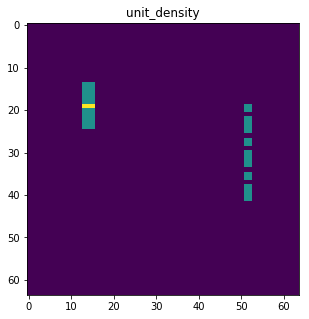

In [11]:
screenIndex = 14 # choose a number between 0 and 16
plt.figure(figsize=(5,5))
plt.imshow( obs[0].observation['screen'][screenIndex])
plt.title(titles[screenIndex])
plt.show()

## 1.3 - 使用 API 发出动作

现在我们已经探索了 sc2 引擎产生的观测结果。下面我们来尝试执行一些可发送至引擎的动作，这样引擎就能作出响应并生成下一个步骤或观测结果。

用于在“星际争霸 (StarCraft)”中发出动作的 python 函数式 API 能让我们生成整套动作，供人类玩家通过鼠标和键盘进行交互。

现在我们来看看代理目前可发出哪些动作。

In [12]:
for iAction in obs[0].observation['available_actions']:
    print( actions.FUNCTIONS[iAction] )

0/no_op ()
1/move_camera (1/minimap [0, 0])
2/select_point (6/select_point_act [4]; 0/screen [0, 0])
3/select_rect (7/select_add [2]; 0/screen [0, 0]; 2/screen2 [0, 0])
4/select_control_group (4/control_group_act [5]; 5/control_group_id [10])
5/select_unit (8/select_unit_act [4]; 9/select_unit_id [500])
7/select_army (7/select_add [2])
12/Attack_screen (3/queued [2]; 0/screen [0, 0])
331/Move_screen (3/queued [2]; 0/screen [0, 0])
332/Move_minimap (3/queued [2]; 1/minimap [0, 0])
333/Patrol_screen (3/queued [2]; 0/screen [0, 0])
334/Patrol_minimap (3/queued [2]; 1/minimap [0, 0])
13/Attack_minimap (3/queued [2]; 1/minimap [0, 0])
274/HoldPosition_quick (3/queued [2])
451/Smart_screen (3/queued [2]; 0/screen [0, 0])
452/Smart_minimap (3/queued [2]; 1/minimap [0, 0])
453/Stop_quick (3/queued [2])


如要了解如何将一系列鼠标和键盘操作转换为函数式 API 调用，可以参考以下动画图形。

<img src="https://storage.googleapis.com/deepmind-live-cms-alt/documents/Oriol-Fig-Anim-170809-Optimised-r03.gif"></img>

下方展示了我们可以使用函数式 API 发出的几个示例动作。

In [13]:
# do nothing
doNothing = actions.FunctionCall( 0, [] ) 

# rectangle select and add to existing selection, rectangle from (0,0) to (31, 31)
selectRectangle = actions.FunctionCall(3, [[1], [0,0], [31,31]])

# select entire army
selectEntireArmy = actions.FunctionCall(7, [[1]])

接下来，我们将选择所有可用的陆军单位，并让它们攻击屏幕上的一个点（同时我们还要为后续 100 个游戏步骤重新发出此命令）。

In [14]:
# attack screen location ( x=60, y=15 ) -- assumes a mini-game with at least 64x64 tiles
attackScreen = actions.FunctionCall(12, [[0], [60, 15]])

obs = env.step( [ selectEntireArmy ] )
for i in range(100):
    obs = env.step( [ attackScreen ] )

## 1.4 - [可选] 动作类型及构建您自己的动作

本节旨在详述有关 SC2 中编程动作的其他信息。每个动作都有一个特定的结构，这取决于它是否需要修饰符或空间参数。

下面列出了几个可能会有的常见动作特征（非详尽列表）：

```
Type1: action.FunctionCall( functionID )
Type2: action.FunctionCall( functionID, [ [ modifier ] ] ) # e.g., 'select_army'
Type3: action.FunctionCall( functionID, [ [ modifier ], [x1, y1 ] ) # e.g., 'attack_screen'
Type4: action.FunctionCall( functionID, [ [ modifier ], [x1, y1], [x2, y2] ) # e.g., 'select_rect'
```
<b>Type1</b> 属于简单型动作，例如“Stop_quick”(ID: 453) 或“HoldPosition_quick”(ID: 274)，这些动作都不需要任何修饰符或屏幕坐标。

<b>Type2</b> 动作需要一个修饰符 - 在“select_army”(ID: 7) [选择所有存活的陆军单位] 的情况下，修饰符表明应将返回的陆军单位集添加至当前任意选择（例如一个农民单位）还是用其替换现有选择。

<b>Type3</b> 动作需要一个修饰符和单个坐标 - 例如“Attack_screen”(ID: 12) 具有修饰符和单个坐标目标，其中修饰符表示是否应立即执行动作（或将动作添加至执行队列）。

<b>Type4</b> 动作需要一个修饰符和两个屏幕坐标 - 例如“select_rect”(ID: 3) 需要一个修饰符和两个屏幕坐标，其中修饰符表示是否要替换、连结或从现有选择中删去新选择），屏幕坐标表示定义新选择的边框。

我们的 RL 代理只能使用此编程接口与游戏世界交互 - 您不妨尝试创建下方列出的有趣的动作序列！

<b>实用提示：</b>如有需要，您可以随时将游戏状态<b>重置</b>为开始，具体可通过以下命令```obs = env.reset()```来执行此操作
此外，我们还编写了一个 ```safe_action``` 功能（下方显示的几个单元），您可以借助此功能来帮助避免禁止执行的动作。


In [15]:
# add your code here

## 1.5 - 随机动作

我们已在下方为一个随机选择攻击点的代理编写了代码。您可能会发现，即使是随机代理也能偶然发现良好的行为；事实上，我们最初随机初始化代理参数时，正是据此来自动开启学习过程。

In [16]:
"""
If the action we chose can't be executed lets try to select our entire army, 
advance the game state, and try again.
"""

def safe_action ( actionToTake, obs ):
    if actionToTake.function not in obs.observation['available_actions']:
        print('unable to take selected action...lets try to fix things')
        print('fix#1: select all army units')
        obs = env.step( [ selectEntireArmy ] )
        print('fix#2: perform no-op action')
        obs = env.step( [ doNothing ] )
        if actionToTake.function not in obs[0].observation['available_actions']:
            print('!we are really in trouble...consider taking a different action')
    else:
        obs = env.step( [ actionToTake ] )
    return obs

In [17]:
# obs = env.reset()
nCycles = 1000
for iCycles in range ( nCycles ):    
    randomAttackScreen = actions.FunctionCall( 12, [[0], [np.random.randint(63), np.random.randint(63)]])
    obs = safe_action ( randomAttackScreen, obs[0] )

unable to take selected action...lets try to fix things
fix#1: select all army units
fix#2: perform no-op action
unable to take selected action...lets try to fix things
fix#1: select all army units
fix#2: perform no-op action


<a id='section2'></a>
# 第 2 节 - 奖励塑造

由 DRL 训练的代理可以根据其训练环境（模拟器）和环境给予它们的奖励来学习行为。我们在相同的环境中训练了两个代理，游戏环境选取的是一张简易的迷你地图，并由两个蟑螂游戏包分离开来。

## 2.1 - 通过 SC2 地图编辑器指定奖励
我们使用地图编辑器来更改逻辑，以便控制环境所产生的奖励。如果您想构建自己的迷你游戏或修改现有的游戏，请下载并安装可免费游玩的“星际争霸 (StarCraft)”客户端，其中包括地图编辑器。然后，您可以通过修改地形或调整触发器中的逻辑来编辑地图。下方展示了默认设置的“消灭蟑螂 (DefeatRoaches)”地图的逻辑屏幕截图，其中每杀死一只蟑螂，都会增加 10 分（仅供参考：玩家一是我们的 RL 代理，玩家二是游戏中的脚本化 AI）。

<img src="images/map_editor.jpg"></img>

## 2.2 - 奖励修改和紧急行为

我们利用 SC2 地图编辑器，构建了几种不同的“消灭蟑螂 (DefeatRoaches)”地图。在一个实例中，每流失一秒，我们就会施加惩罚，以此鼓励代理主动出击。经过长时间训练后，请执行以下单元查看此代理的记录。注意，上文中的代理一直在四处移动以寻找要击杀的敌人。通过更快速地发现及击杀所有蟑螂，此代理可获得更高的分数。

In [19]:
%%HTML
<center><iframe width="560" height="315" src="https://www.youtube.com/embed/8eRFzXtBdwA?rel=0" frameborder="0" allow="autoplay; encrypted-media" allowfullscreen></iframe></center>

接下来我们制作了一张地图，其将针对小队成员的损失施加更严厉的惩罚。请执行以下单元查看这个不善主动出击的代理。

In [20]:
%%HTML
<center><iframe width="560" height="315" src="https://www.youtube.com/embed/9Opgktl6kLo?rel=0" frameborder="0" allow="autoplay; encrypted-media" allowfullscreen></iframe></center>

那位好斗的代理一直在四处寻找要击杀的蟑螂，而这位保守的代理却更乐意在角落里闲逛，以免损失任何陆战队员。

<a id='section3'></a>
# 第 3 节 - 跟踪学习过程

通过查看代理所能获得的奖励，我们能够加深对它的了解。通过绘制这些训练时间或所见帧数的曲线，我们便能得到一条奖励曲线。我们使用 Tensorflow 的 Tensorboard 绘制了曲线。您可以在此 [链接](/tensorboard/) 中检阅许多不同代理的曲线。

单击“toggle all runs”（触发所有运行进程），然后单击您想要探索的运行进程。稍后我们便会捕捉到许多指标，且 sc2 或 episode_score 会获得环境给予代理的分数。

我们使用此开源 repo 来训练代理：https://github.com/simonmeister/pysc2-rl-agents.git 下图展示了在“消灭蟑螂 (DefeatRoaches)”迷你游戏中训练的代理的奖励曲线。
<center>
<img src="images/DefeatRoaches.PNG" width="75%"></img>
</center>
您可从学习曲线中看到，代理通常必须牺牲自己的分数方能学习一种新策略，最终取得更出色的游戏表现。下方提供了两个视频。第一个是只训练了一半的代理，第二个是完整训练后的代理。

## 3.1 - 只训练了一半的代理

In [21]:
%%HTML
<center><iframe width="560" height="315" src="https://www.youtube.com/embed/tzPrtTXPTEA?rel=0" frameborder="0" allow="autoplay; encrypted-media" allowfullscreen></iframe></center>

注意，代理已经学会将注意力集中在蟑螂身上。不过，它仍在学习，并会花些时间点击地图的各个点。

训练结束时，此代理效率惊人，并能轻松聚焦在蟑螂身上。运气好的话，代理将能斩获超高分！

In [22]:
%%HTML
<center><iframe width="560" height="315" src="https://www.youtube.com/embed/IBUgp6097Q0?rel=0" frameborder="0" allow="autoplay; encrypted-media" allowfullscreen></iframe></center>

## 3.2 - 多个环境

让代理同时在多个环境中运行可以加快其学习速度。我们使用 16 个环境同时训练其中一个代理，而对另一个代理则只使用一个环境。


<img src="images/MoveToBeaconNenvs.PNG" width="75%"></img>
在 16 个环境中训练的代理能够在 20 分钟内掌握“寻路 (MoveToBeacon)”迷你地图的游戏技能，而只使用 1 个环境训练的代理则需要 2 小时 20 分钟。

“寻路 (MoveToBeacon)”是一个十分简单的迷你游戏，因此只在一个环境中学习的代理仍然可以掌握它。对于更复杂的环境而言，代理通常需要在多个环境中进行训练，以便学习掌握游戏所需的高级策略。

浏览 [TensorBoard](/tensorboard/)，进一步探索奖励曲线。TensorBoard 也有一条为同时在 8 个环境中训练的代理绘制的奖励曲线。

<a id='section4'></a>
# 第 4 节 - 混合与匹配代理和环境

在本节中，您可以选择一个代理，然后让该代理玩一个迷你游戏。您可以自由试验，探索不同的代理在不同环境下会有何表现。下方展示了一个可用代理列表以及可将其部署到的环境。

### 可用代理

* <b>DefeatRoaches</b> - 在“消灭蟑螂 (DefeatRoaches)”地图上受过完整训练的代理
* <b>DefeatRoaches_half_trained</b> - 在“消灭蟑螂 (DefeatRoaches)”地图上受过部分训练的代理
* <b>DefeatRoaches_singleRoundReset_conserveMarines_noTimePenalty_splitRoachPacks</b> - 竭力避免损失单位的代理
* <b>DefeatRoaches_singleRoundReset_highTimePenalty_splitRoachPacks</b> - 必须尽快杀死对手的代理
* <b>MoveToBeacon_n_envs_16</b> - 训练进行寻路的代理

### 环境 [<a href="https://github.com/deepmind/pysc2/blob/master/docs/mini_games.md">详细描述</a>]
<ul>
“训练陆战队员 (BuildMarines)”<b>||</b>“收集散落水晶 (CollectMineralShards)”<b>||</b>“收集水晶和气 (CollectMineralsAndGas)”<br >
“消灭蟑螂 (DefeatRoaches)”<b>||</b>“消灭小狗和毒爆虫 (DefeatZerglingsAndBanelings)”<b>||</b>“寻找并消灭小狗 (FindAndDefeatZerglings)”<br >
“寻路 (MoveToBeacon)”
</ul>

如要加载代理，我们必须指定地图和检查点。输入下方的代理名称以查看模型检查点编号。

In [23]:
!ls /notebooks/models/DefeatRoaches

checkpoint			       model.ckpt-250000.index
model.ckpt-250000.data-00000-of-00001  model.ckpt-250000.meta


“检查点”文件会指向要加载的模型。

In [24]:
!echo "model_checkpoint_path: \"/notebooks/models/DefeatRoaches/model.ckpt-250000\"" > /notebooks/models/DefeatRoaches/checkpoint

在完成 10 次训练之后，回放将被写入磁盘。

完成后，请单击工具栏上的 ```Stop```（停止）按钮或前往 ```Kernel```（内核）菜单，然后选择 ```Interrupt ```（中断），这样您便可执行更多单元。

In [25]:
!python /notebooks/pysc2-rl-agents/run.py \
  DefeatRoaches \
  --map DefeatRoaches \
  --max_windows 1 --gpu 0 --envs 1 \
  --step_mul 8 --steps_per_batch 16 \
  --vis --eval \
  --save_dir /notebooks/models \
  --summary_dir /notebooks/summary \
  --iters 250

/usr/local/lib/python2.7/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
2018-11-23 01:19:41.864234: I tensorflow/core/platform/cpu_feature_guard.cc:137] Your CPU supports instructions that this TensorFlow binary was not compiled to use: SSE4.1 SSE4.2 AVX AVX2 FMA
Version: B55958 (SC2.3.16)
Build: Jul 31 2017 13:19:41
Command Line: '"/headless/StarCraftII/Versions/Base55958/SC2_x64" -listen 127.0.0.1 -port 24657 -dataDir /headless/StarCraftII/ -tempDir /tmp/sc-NLrHsV/ -displayMode 0'
Starting up...
Startup Phase 1 complete
2018-11-23 01:19:41.941499: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:892] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2018-11-23 01:19:41.

当生成回放后，您可以执行以下单元压缩文件。

In [26]:
!apt-get update > /dev/null 2>&1 && apt-get install zip > /dev/null 2>&1 && zip /notebooks/replays.zip /notebooks/replays/*

  adding: notebooks/replays/DefeatRoaches_2018-11-23-01-20-09.SC2Replay (deflated 15%)
  adding: notebooks/replays/DefeatRoaches_2018-11-23-01-20-30.SC2Replay (deflated 9%)
  adding: notebooks/replays/DefeatRoaches_2018-11-23-01-20-48.SC2Replay (deflated 7%)


[单击此处下载回放。](replays.zip)

如要使用本地客户端查看回放，请将回放文件置于 ```~/StarCraftII/replays```，并将迷你游戏置于 ```~/StarCraftII/Maps/mini_games``` 中。您可以在 [此处](https://github.com/deepmind/pysc2/tree/master/pysc2/maps/mini_games) 下载迷你游戏。

<a id='section5'></a>
# 第 5 节 - 构建并训练自己的代理

我们希望您喜欢本实验，也希望您能学到一些关于 RL 和 SC2 的新知识。我们只是介绍了一些浅显知识，如果您有意深究，我们将乐意提供一些工具来进行更多探索。

我们使用基于 TensorFlow 后端的 Keras 为一个自定义代理构建了训练工具，如下所示。我们的目标是为任何有意在 SC2 环境中试验 RL 想法的探究者提供一个易于使用的测试环境。

此代码工具的结构如下：
<ul>
1 - 定义关键参数<br>
2 - 创建多个 SC2 环境<br>
3 - 加载代理代码<br>
4 - 运行交互循环（使用 n-step 轨迹）并更新代理参数<br>
</ul>
从技术角度来说，该训练工具使用 n-step TD 进行学习，并可将观测的帧序列叠加在一起以探究动态变化。

In [ ]:
%%javascript
require(["base/js/dialog"], function(dialog) {dialog.modal({title: 'Cleaning Up', body: 'We need to ensure that no other sc2 environments are active -- lets force a kernel restart', buttons: {'Kernel restart': { click: function(){ Jupyter.notebook.session.restart(); } }}});});
Jupyter.notebook.session.delete();

<IPython.core.display.Javascript object>

In [1]:
import numpy as np
import matplotlib.pylab as plt
import os.path

# required 
from absl import flags
FLAGS = flags.FLAGS
FLAGS(['initialize FLAGS for sc2 environments'])

# note this import must happen after flag initialization
from pysc2.env import sc2_env
from pysc2.lib import actions
from pysc2.lib import features

# 5.1 - 定义参数

In [2]:
envParams = { 
    'simultaneousEnvironments': 4,
    'nEnvironmentsToVisualize': 4,
    'nTrajectorySteps': 16,
    'nStackedFrames': 4,
    'agentStepsPerEnvironmentStep': 4,
    
    'batchCheckpointInterval': 100,
    'experimentDirectory': '/experiments',
    'debugFlag': False,
    
    'screenResX': 64,
    'screenResY': 64,
    'screenResX_minimap': 32,
    'screenResY_minimap': 32,
    
    'screenChannelsToKeep': [ 4, 5, 6, 7, 8, 9 ], # player_ID, player_relative, unit_type, selected, unit_hit_points, unit_hit_points_ratio
    'screenChannelsRetained': 6,

    'nonSpatialInputDimensions': 12, 
    'allowedActionIDs': [ 3, 12 ], # select_rect, attack_screen
    'allowedActionIDRequiresModifier': [ 2, 1 ],            
    'allowedActionIDRequiresLocation': [ 2, 1 ],       

    'prunedActionSpaceSize': 2,
    'actionArgumentSize': 4, 

    'nonVisualInputLength': 13,
    
    'futureDiscountRate': 1,   
    'stepTypeFirst': 0,
    'stepTypeMid': 1,
    'stepTypeLast': 2,
    
    'entropyWeight': .25,
    'policyWeight': 1,
    'valueWeight': .5,
    
}

# sanity check environment parameter definition
assert ( envParams['prunedActionSpaceSize'] == len(envParams['allowedActionIDs']) \
            == len(envParams['allowedActionIDRequiresModifier']) \
            == len(envParams['allowedActionIDRequiresLocation']) )
assert ( envParams['screenChannelsRetained'] == len(envParams['screenChannelsToKeep'] ) )


assert ( envParams['nStackedFrames'] <= envParams['nTrajectorySteps'])

sc2EnvLaunchParams = {
    'map_name':'DefeatRoaches',
    'step_mul': envParams['agentStepsPerEnvironmentStep'],
    'game_steps_per_episode': 0, # no limit
    'screen_size_px': ( envParams['screenResX'], envParams['screenResX']), 
    'minimap_size_px': ( envParams['screenResX_minimap'], envParams['screenResY_minimap']),
    'visualize': False,
    'score_index': None 
}
sc2EnvLaunchParamsVis = sc2EnvLaunchParams.copy()
sc2EnvLaunchParamsVis['visualize'] = True

# 5.2 - 启动多个环境

接下来，我们将派生多个并行的工作进程，每个进程都自带内存空间且会运行一个 sc2 linux 客户端实例。每个工作进程都将通过一个双向通信管道连接到当前进程（笔记本内核），我们可通过此管道发送请求并与其中的 sc2 环境进行交互。

<img src="images/multi_process.PNG" style="width:40%">

对于每个管道而言，连接至主进程的末端称为局部末端，而连接至工作进程的末端则称为远程末端。我们使用管道末端在进程之间进行通信，通信时使用 ```.send()``` 命令进行传输并使用 ```.recv()``` 命令来监听回应。

In [3]:
from multiprocessing import Process, Pipe
import time

# define the function running in each [forked] worker to parse communications between itself and the main process
def sc2_remote_env_manager ( workerID, remotePipeEnd, sc2EnvLaunchParams ):
    print('starting remote sc2 environment thread# ' + str(workerID))
    env = sc2_env.SC2Env(**sc2EnvLaunchParams)
    obs = env.reset()    
    remotePipeEnd.send( ( 'launch complete', obs[0]) )
    
    while True:
        command, arguments = remotePipeEnd.recv()
        # take action and advance the game environment 
        if command == 'step': 
            obs = env.step( [ arguments ] )
            assert( len(obs) == 1 )
            remotePipeEnd.send( obs[0] )
        elif command == 'reset':
            obs = env.reset()    
            remotePipeEnd.send( obs[0] )
        # close the pipe and sc2 environment
        elif command == 'close':
            remotePipeEnd.send('closing')
            remotePipeEnd.close()
            break
        else:
            raise NotImplementedError

localPipeEnds = [] # pipe-ends/communication channels used by the main process to communicate with workers
remotePipeEnds = [] # pipe-ends/communication channels used by the workers to communicate with the main process
processList = [] # list of worker threads

# create two-way-communication channels [aka pipes] for remote workers and our main program
# and spawn remote processes with remote pipe ends as an input argument
for iEnv in range(envParams['simultaneousEnvironments']):
    # create new pipe
    localPipeEnd, remotePipeEnd = Pipe()
    # store both ends 
    localPipeEnds += [ localPipeEnd ]
    remotePipeEnds += [ remotePipeEnd ]
    # spawn remote process and connect to remote pipe end
    if iEnv < envParams['nEnvironmentsToVisualize']:
        processList += [ Process( target = sc2_remote_env_manager , args = ( iEnv, remotePipeEnd, sc2EnvLaunchParamsVis) ) ]
    else:        
        processList += [ Process( target = sc2_remote_env_manager , args = ( iEnv, remotePipeEnd, sc2EnvLaunchParams) ) ]

In [4]:
obs = {}
for iEnv in range ( envParams['simultaneousEnvironments'] ):
    obs[iEnv] = None

In [5]:
# start remote workers, wait for each process to fully bring up the sc2 environment before creating the next
for iEnv in range(envParams['simultaneousEnvironments']):
    processList[iEnv].start()
    while not localPipeEnds[iEnv].poll():
        time.sleep(1)
    msg, obs[iEnv] = localPipeEnds[iEnv].recv()
    print ( msg )

starting remote sc2 environment thread# 0
launch complete
starting remote sc2 environment thread# 1
launch complete
starting remote sc2 environment thread# 2
launch complete
starting remote sc2 environment thread# 3
launch complete


### <center>单击 [noVNC Server](http://ec2-18-221-145-178.us-east-2.compute.amazonaws.com:6900/?password=vncpassword)（noVNC 服务器）查看环境。</center>

# 5.3 - 加载代理代码

以下显示了 [一个卷积代理的代码](../edit/convolutional_agent.py) - 您可以随时试验此代码并作出改进！
此代理由基础版 [sc2_agent](../edit/convolutional_agent.py) 衍生而来 - 您可将此代理视作骨架，将卷积代理视作实际进行特征提取的大脑。


In [6]:
''' if using python3 uncomment -> ''' # from importlib import reload 
import convolutional_agent as sc2RL
reload(sc2RL);

/usr/local/lib/python2.7/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [7]:
agent = sc2RL.ConvAgent( envParams )

hi I'm the CONV-AGENT
 | architecture: im a simple conv agent
 | learning strategy: backprop


In [8]:
agent.model_summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 24, 64, 64)   0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 64, 64)   12320       input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 32, 64, 64)   16416       conv2d_1[0][0]                   
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 48)           0                                            
__________________________________________________________________________________________________
flatten_3 

In [9]:
# reset environments
for iEnv in range( envParams['simultaneousEnvironments'] ):
    localPipeEnds[iEnv].send ( ( 'reset', [] ) )
    obs[iEnv] = localPipeEnds[iEnv].recv()

# 5.4 - 行动 - 观察 - 学习 [循环]

<img src="images/RL_diagram.PNG"></img>

In [10]:
np.random.seed(1)
trainBatches = 15 # change to a large number or replace first for loop with a 'while True:' loop

for iTrajectory in range(trainBatches):
    for iStep in range ( envParams['nTrajectorySteps'] + 1):        
        ''' batch predict model outputs on current inputs ''' # [ 1 timestep in multiple environments ]
        batchModelOutputs = agent.batch_predict ( np.squeeze( agent.nEnvOneStepBatch, axis=1),
                                                      np.squeeze( agent.nEnvOneStepBatchNonSpatial, axis=1)  )
        
        ''' update trajectory rewards and value estimates '''
        agent.rewards[:, iStep ] = [ obs[iEnv].reward for iEnv in list(obs.keys()) ]
        agent.valuePredictions[:, iStep] = batchModelOutputs[:, agent.policyInds['value']]
        
        if iStep != envParams['nTrajectorySteps']: # don't advance when in the final step -- use it to bootstrap loss computation
            ''' sample and mask '''
            sc2functionCalls, actionIDs, actionArguments = \
                agent.sample_and_mask ( obs, batchModelOutputs )

            ''' compute partial loss terms ''' # logProbs and masked policy entropy
            agent.inplace_update_logProbs_and_entropy ( iStep, batchModelOutputs )

            ''' step i.e. apply selected action in each environment ''' # and get new observations
            obs, _ = agent.step_in_envs ( obs, localPipeEnds, sc2functionCalls, actionIDs )

            ''' compile the spatial and non-spatial trajectory observations ''' # needed for batch train update
            agent.inplace_update_trajectory_observations( iStep, obs )
        
    ''' finished generating a trajectory -- compute nStep returns, advantages, and cumulative loss '''
    agent.compute_loss ()
    agent.train()
    
    print( 'trajectory# ' + str(trainBatches) + ' avg step reward: ' + str(np.mean( np.mean( agent.rewards ))))
    if (trainBatches + 1) % envParams['batchCheckpointInterval'] == 0:
        agent.model_checkpoint()            
    trainBatches += 1

trajectory# 15 avg step reward: 0.0
trajectory# 16 avg step reward: 0.0
trajectory# 17 avg step reward: -0.014705882
trajectory# 18 avg step reward: 0.11764706
trajectory# 19 avg step reward: 0.11764706
trajectory# 20 avg step reward: -0.014705882
trajectory# 21 avg step reward: -0.029411765
trajectory# 22 avg step reward: -0.014705882
trajectory# 23 avg step reward: 0.0
trajectory# 24 avg step reward: 0.11764706
trajectory# 25 avg step reward: 0.11764706
trajectory# 26 avg step reward: 0.14705883
trajectory# 27 avg step reward: 0.13235295
trajectory# 28 avg step reward: 0.0
trajectory# 29 avg step reward: -0.04411765


## 结束语

感谢您参与本实验。如果您想进一步探索强化学习的缤纷世界，请随时探索以下资源：

Udacity 深度学习强化课程
https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893

DeepMind 对深度学习强化方法的概述
https://deepmind.com/blog/deep-reinforcement-learning/

探讨策略梯度网络的博文
https://medium.com/@gabogarza/deep-reinforcement-learning-policy-gradients-8f6df70404e6

